In [37]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
INPUT_FILE_VAL1 = "../processing/leaf_segmentation/metrics/maskrcnn_mobilenet_fpn/metrics_val_1721761097.061419.csv"
INPUT_FILE_TRAIN1 = "../processing/leaf_segmentation/metrics/maskrcnn_mobilenet_fpn/metrics_train_1721761097.061419.csv"
INPUT_FILE_VAL2 = "../processing/leaf_segmentation/metrics/retinanet_resnet_fpn/metrics_val_1721823305.5470974.csv"
INPUT_FILE_TRAIN2 = "../processing/leaf_segmentation/metrics/retinanet_resnet_fpn/metrics_train_1721823305.5470974.csv"

In [20]:
def plot_df(df):
    plt.figure()
    nunique = df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    df = df.drop(cols_to_drop, axis=1)
    df.plot(kind="line", x="step")

In [21]:
def drop_invariant(df):
    nunique = df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    df = df.drop(cols_to_drop, axis=1)
    return df, cols_to_drop

In [22]:
def merge_dfs(df1, df2, only_shared=True):
    # Create a new DataFrame to store the merged columns
    merged_df = pd.DataFrame()

    if only_shared:
        df1_cols = set(df1.columns)
        df2_cols = set(df2.columns)

        shared_cols = df1_cols.intersection(df2_cols)
        
        for col in shared_cols:
            for i, df in enumerate([df1, df2]):
                merged_df[f'{col}_df{i + 1}'] = df[col]
        return merged_df, shared_cols
    
    # Merge columns from both DataFrames
    for col in df1.columns:
        merged_df[f'{col}_df1'] = df1[col]
        if col in df2.columns:
            merged_df[f'{col}_df2'] = df2[col]

    for col in df2.columns:
        if col not in df1.columns:
            merged_df[f'{col}_df2'] = df2[col]
    return merged_df

In [33]:
df1t = pd.read_csv(INPUT_FILE_TRAIN1)
df2t = pd.read_csv(INPUT_FILE_TRAIN2)

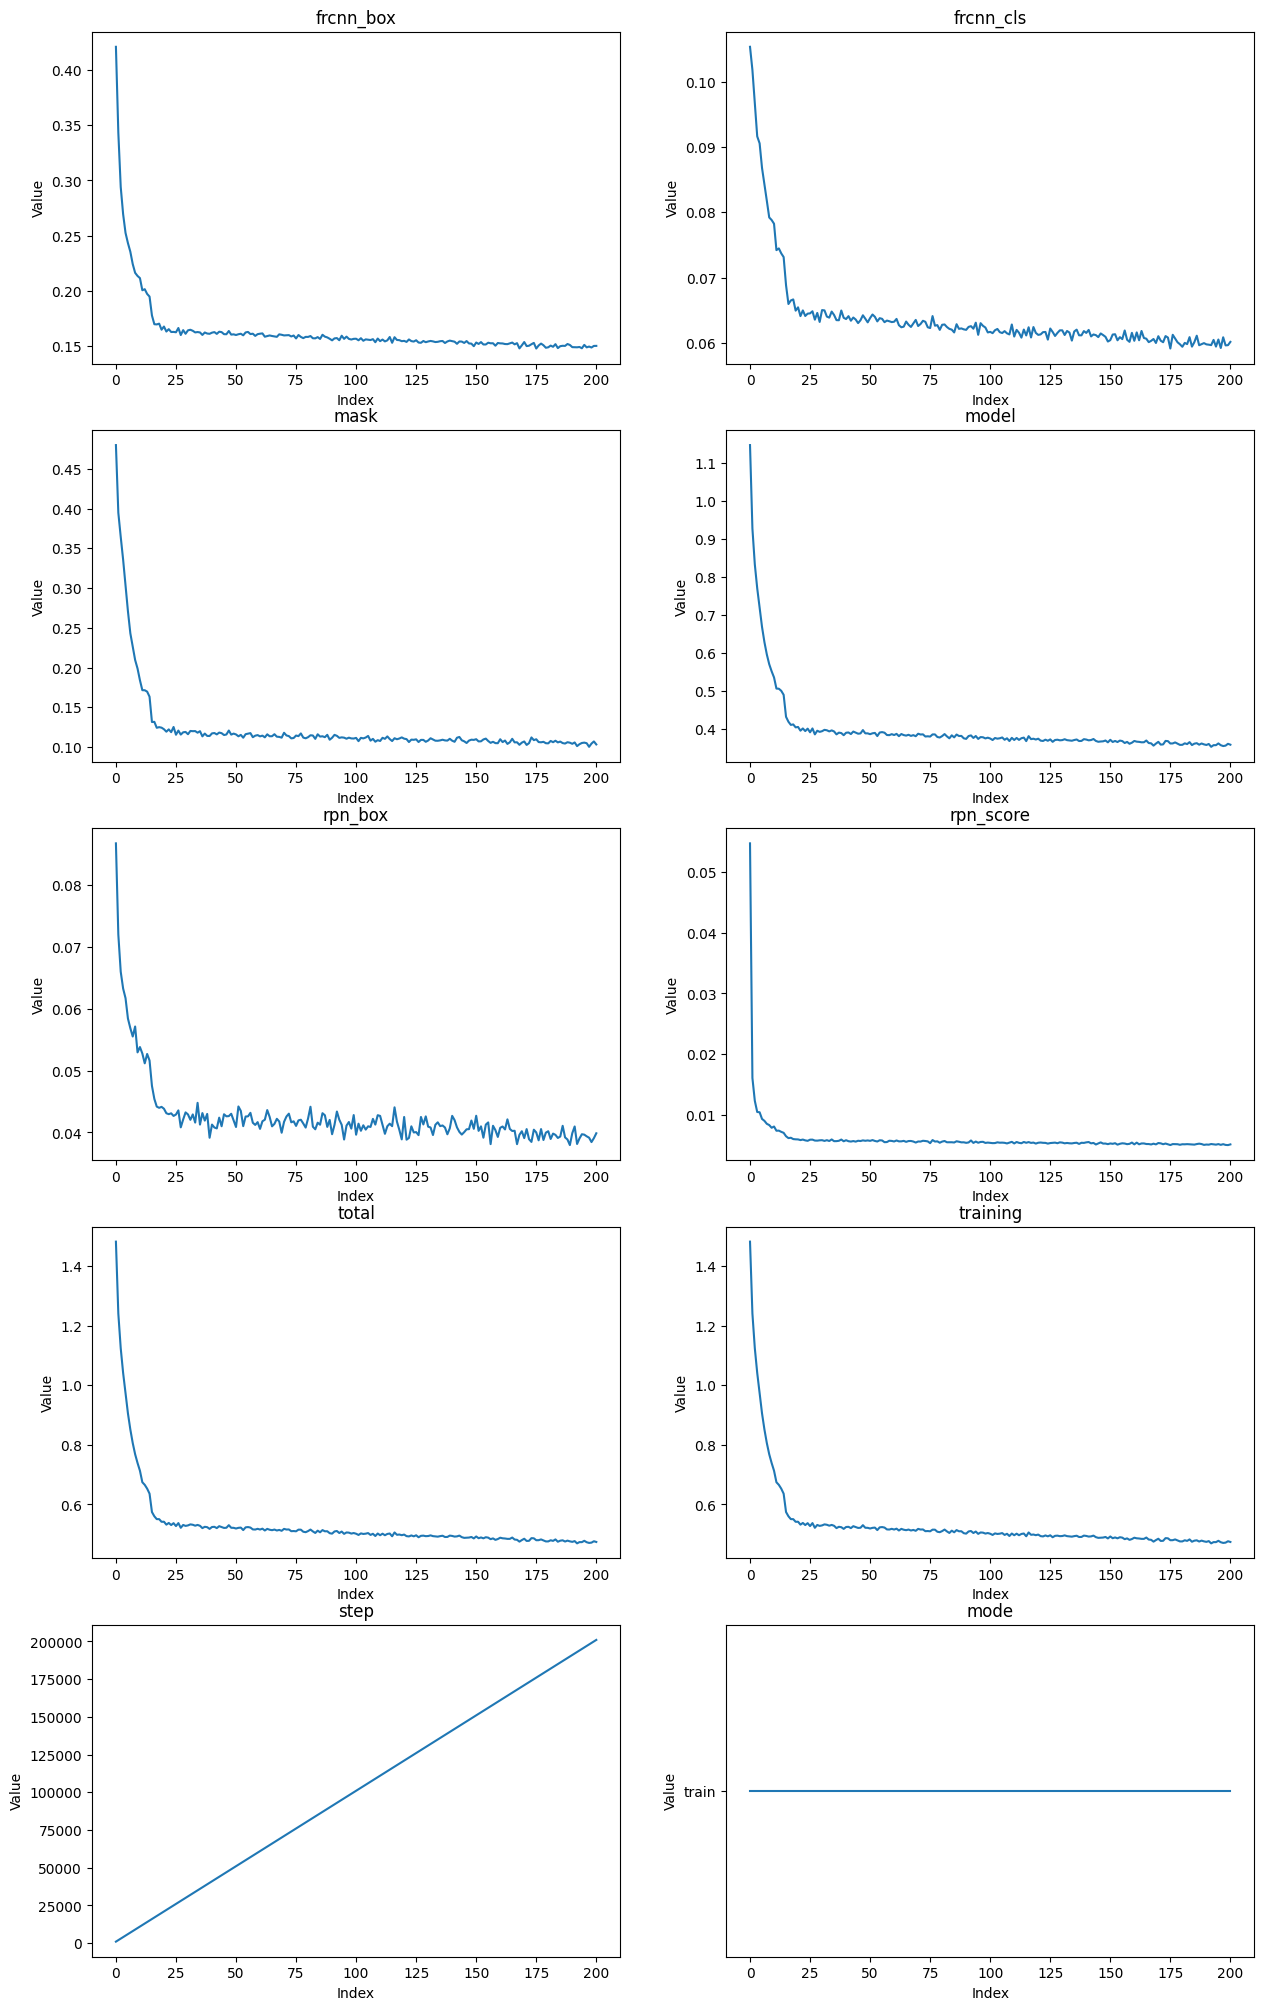

In [36]:
n_cols = len(df1t.columns)
n_rows = (n_cols + 1) // 2  # Round up to the nearest integer

# Create subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each column
for i, col in enumerate(df1t.columns):
    axes[i].plot(df1t[col])
    axes[i].set_title(col)
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Value')

/tmp/ipykernel_2584033/1979608301.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()


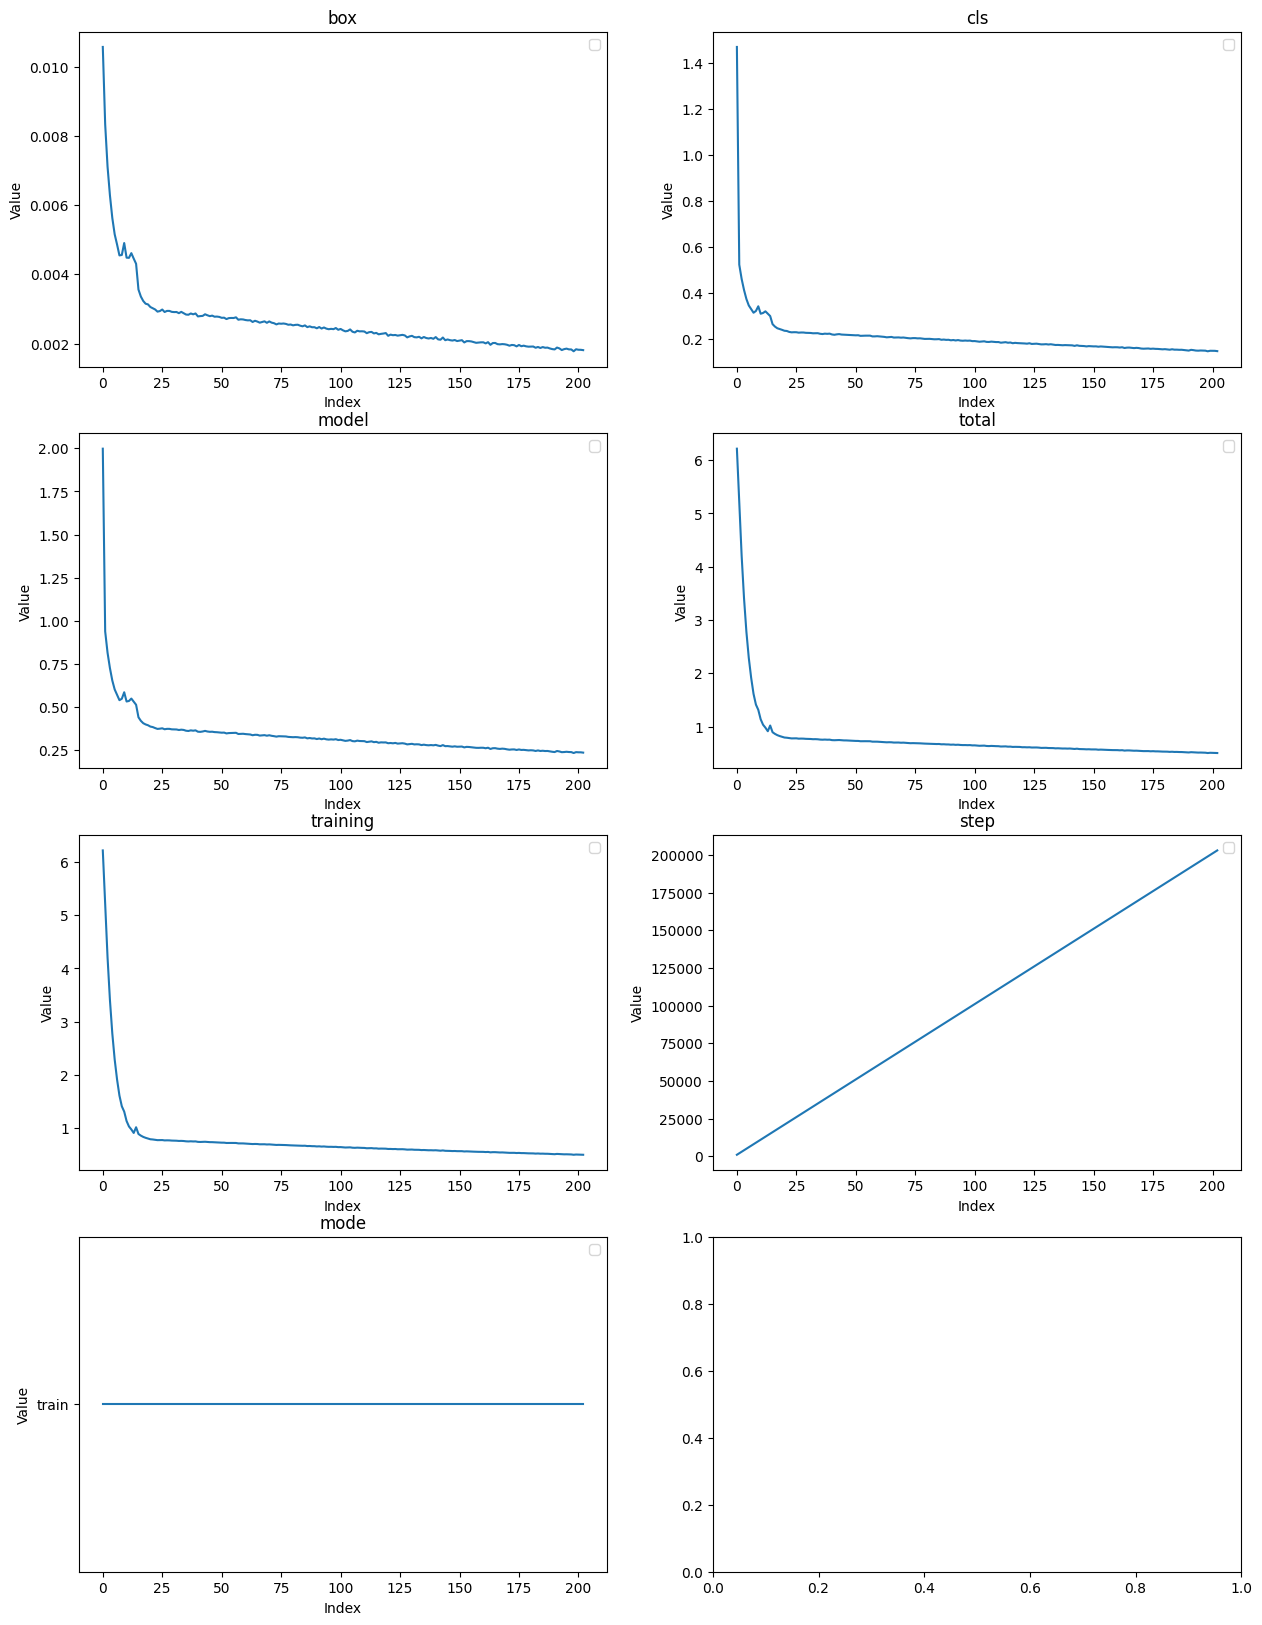

In [35]:
n_cols = len(df2t.columns)
n_rows = (n_cols + 1) // 2  # Round up to the nearest integer

# Create subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each column
for i, col in enumerate(df2t.columns):
    axes[i].plot(df2t[col])
    axes[i].set_title(col)
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Value')

In [39]:
df1t = df1t.rename(lambda name: re.sub(r'frcnn_', '', name), axis="columns")

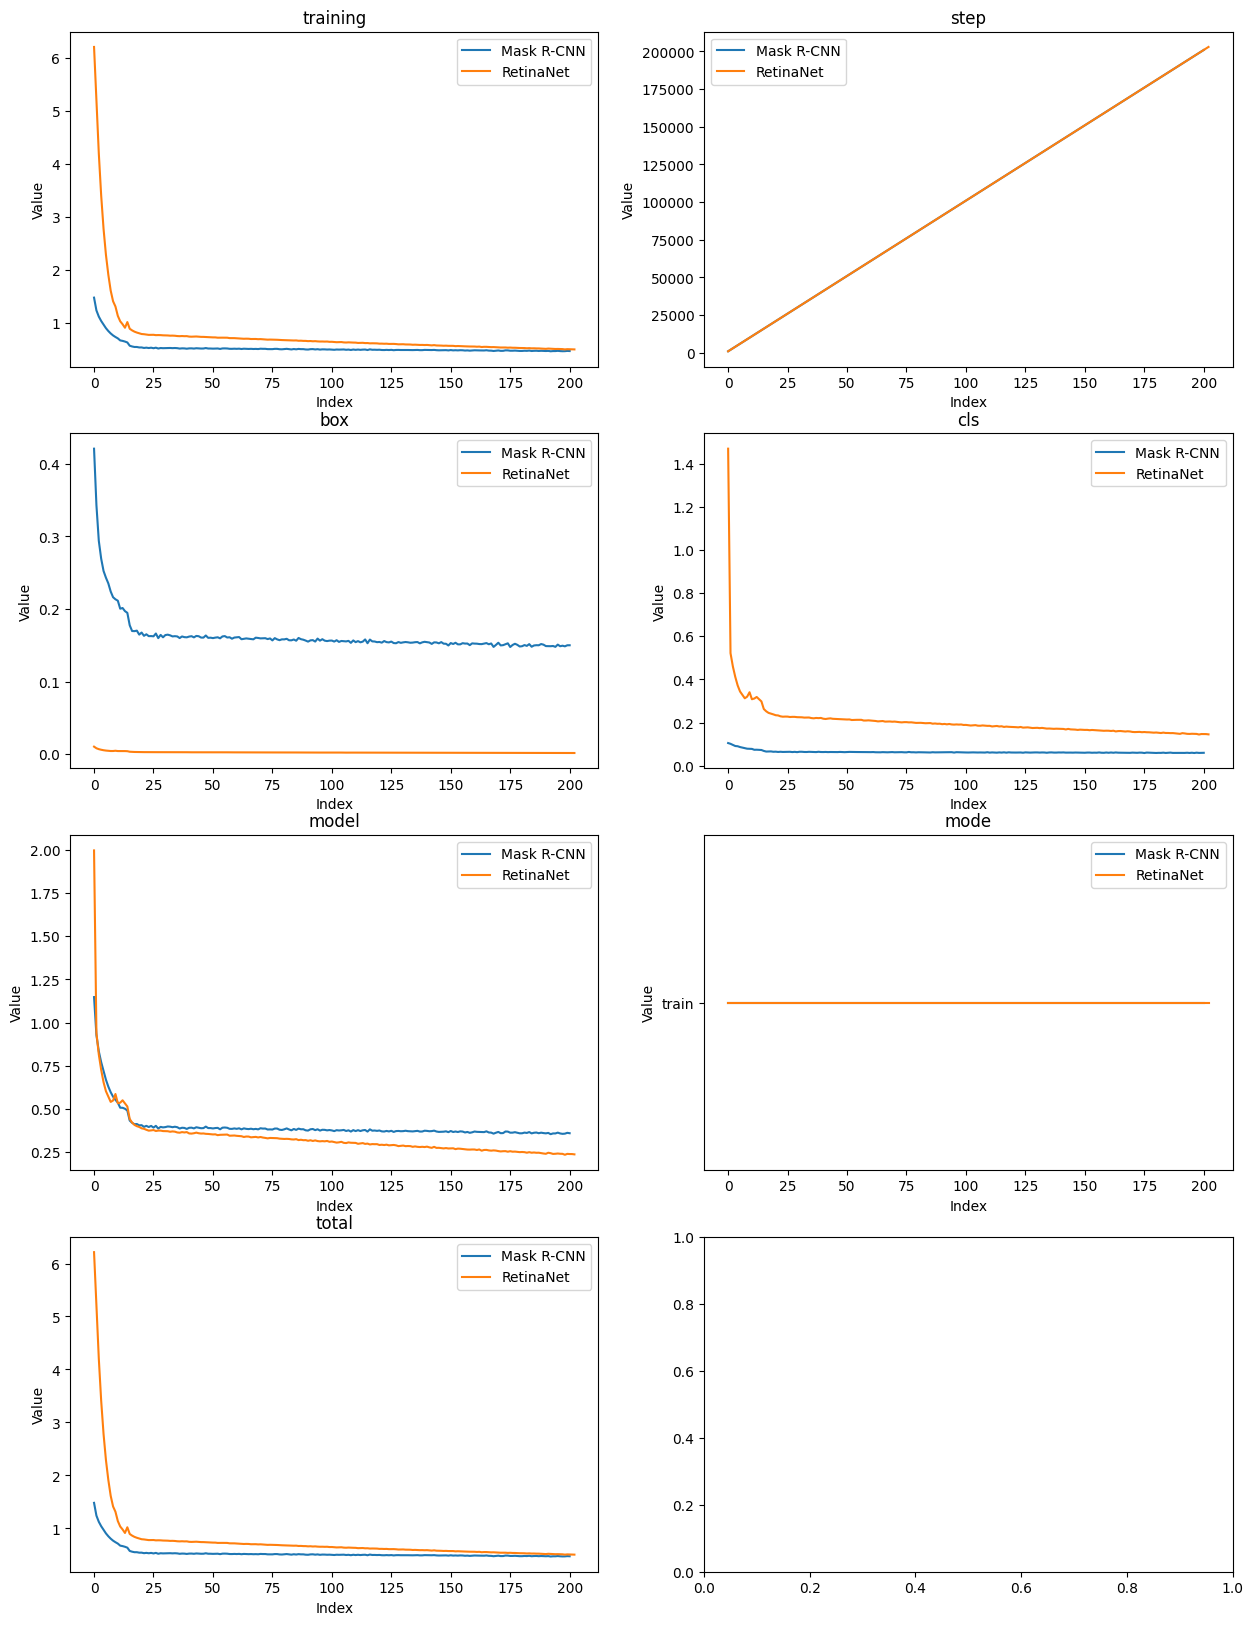

In [46]:
cols = set(df1t.columns).intersection(set(df2t.columns))
n_cols = len(cols)
n_rows = (n_cols + 1) // 2  # Round up to the nearest integer

# Create subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each column
for i, col in enumerate(cols):
    axes[i].plot(df1t[col], label="Mask R-CNN")
    axes[i].plot(df2t[col], label="RetinaNet")
    axes[i].set_title(col)
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Value')
    axes[i].legend()

In [23]:
df1 = pd.read_csv(INPUT_FILE_VAL1)
df2 = pd.read_csv(INPUT_FILE_VAL2)

/tmp/ipykernel_2584033/4179976973.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()


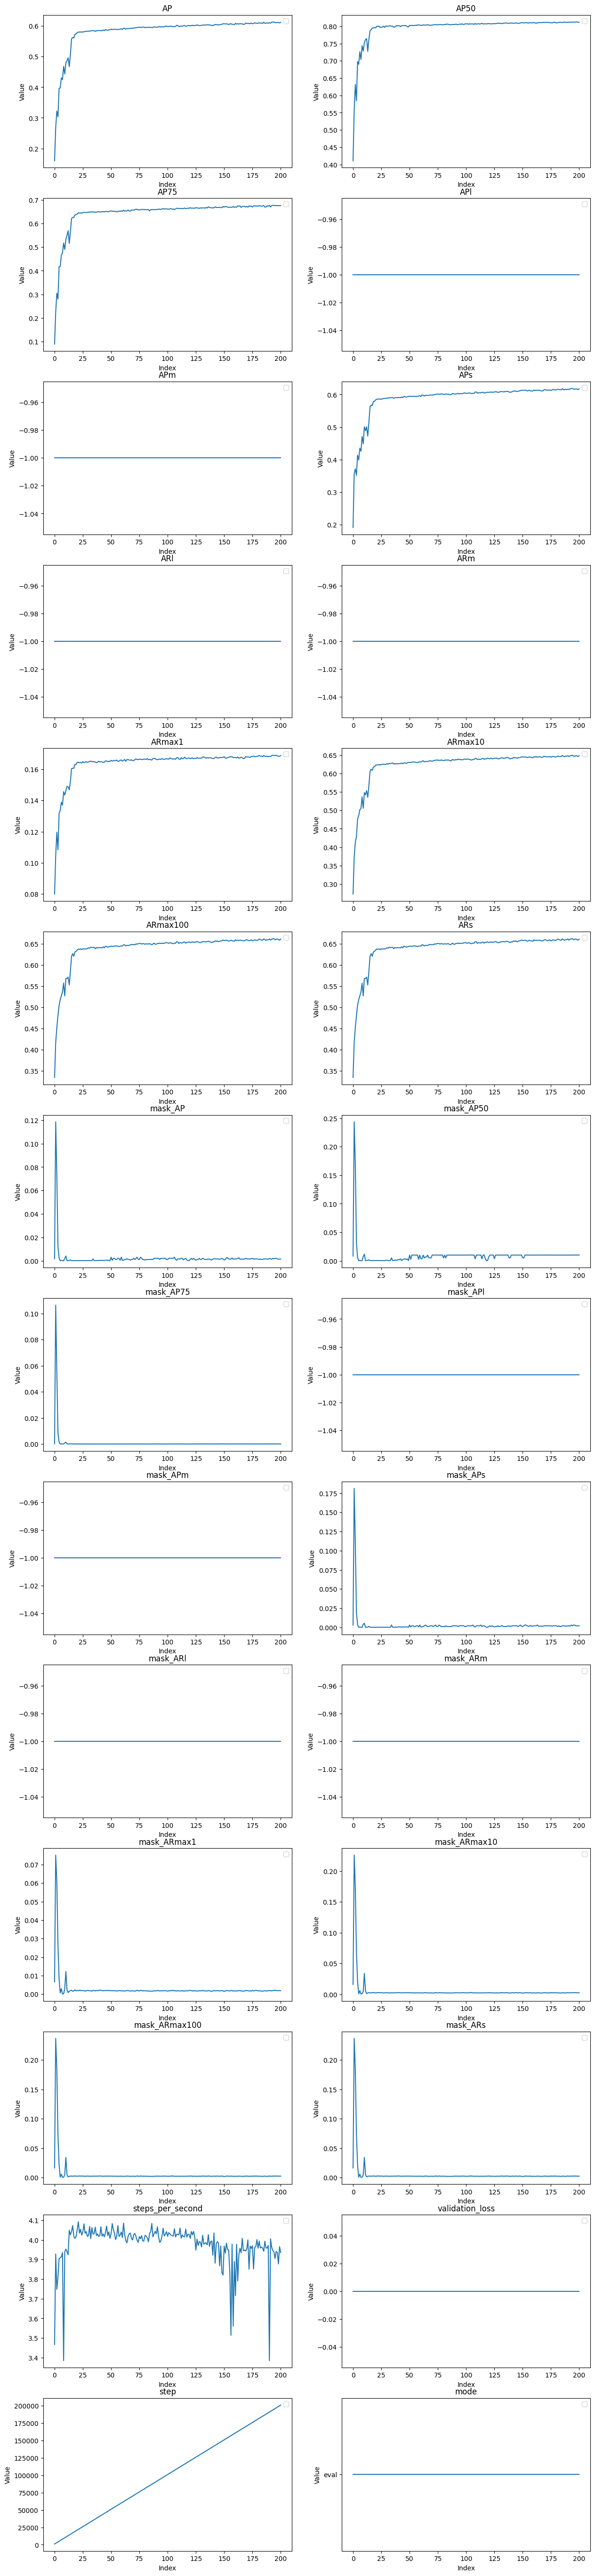

In [24]:
n_cols = len(df1.columns)
n_rows = (n_cols + 1) // 2  # Round up to the nearest integer

# Create subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each column
for i, col in enumerate(df1.columns):
    axes[i].plot(df1[col])
    axes[i].set_title(col)
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Value')
    axes[i].legend()

/tmp/ipykernel_2584033/1250285391.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()


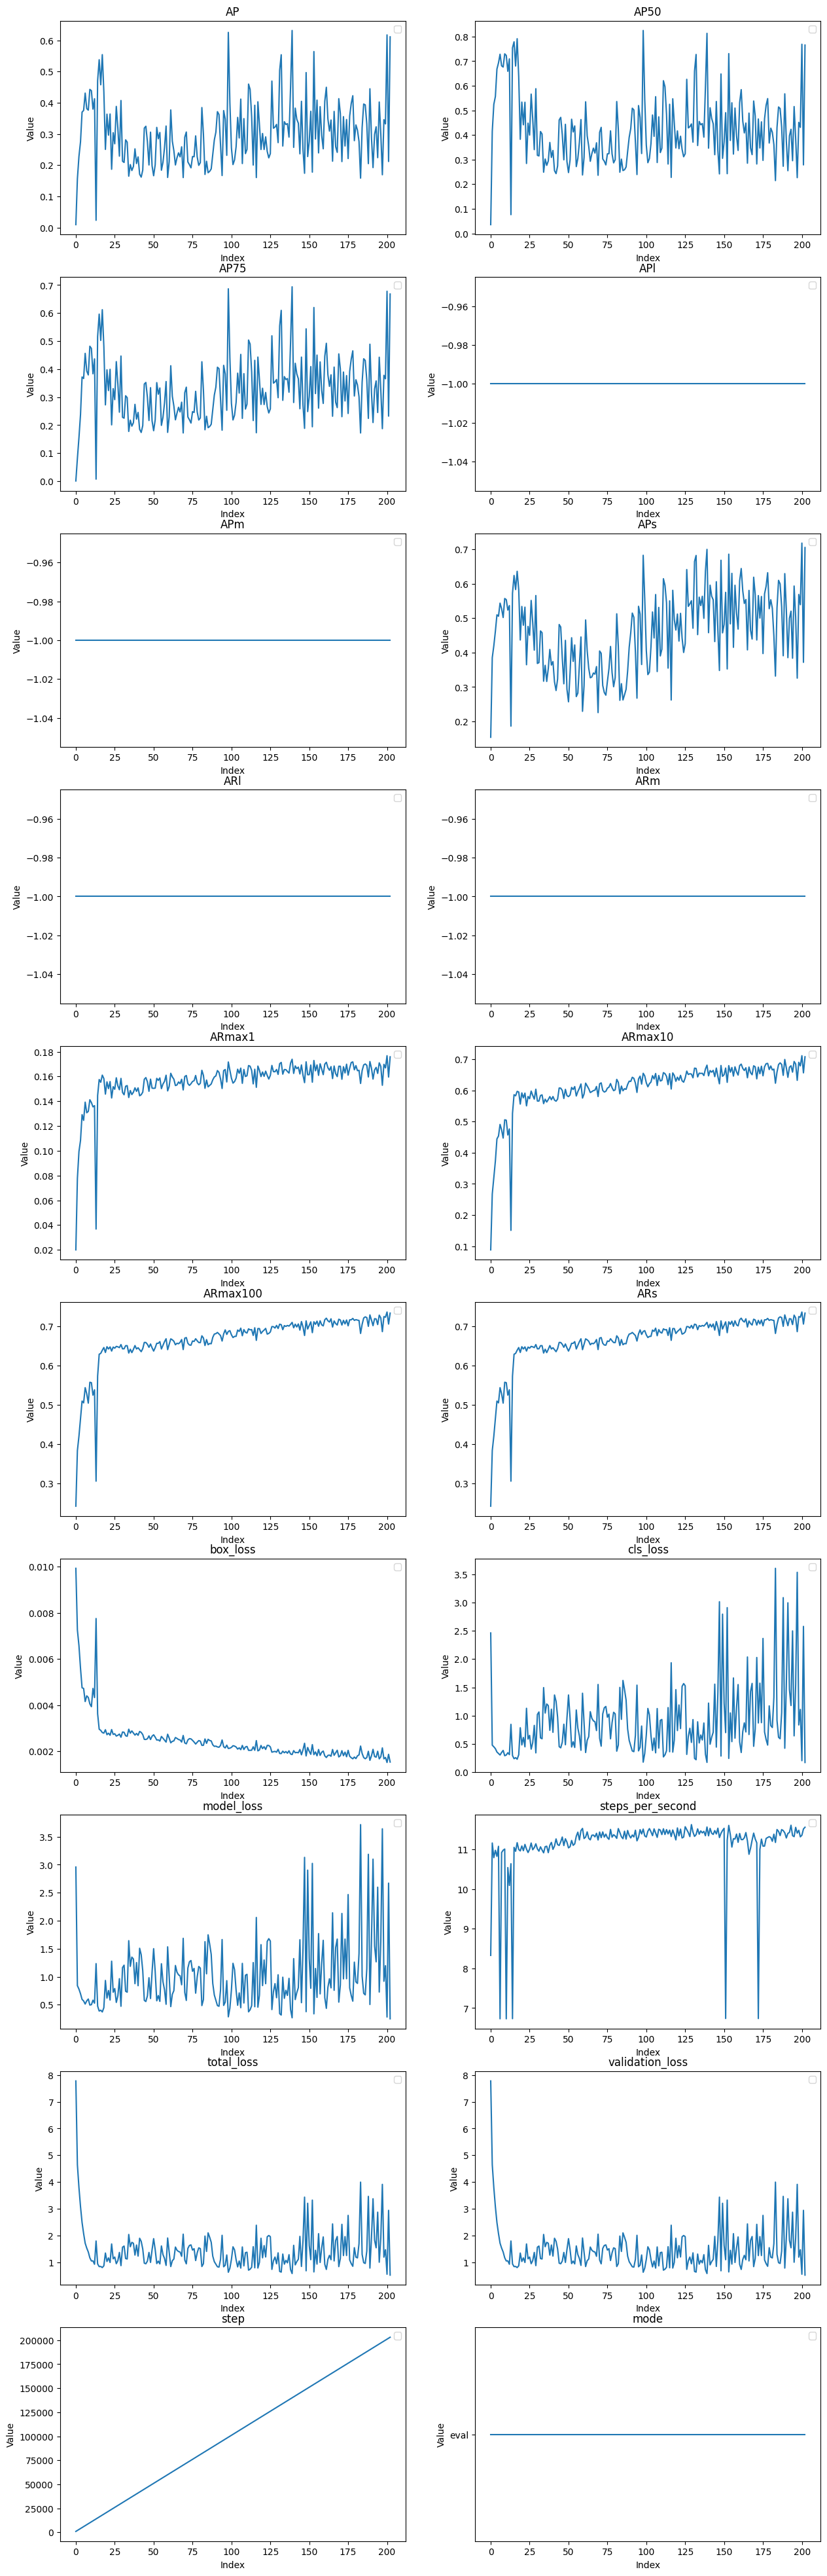

In [25]:
n_cols = len(df2.columns)
n_rows = (n_cols + 1) // 2  # Round up to the nearest integer

# Create subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each column
for i, col in enumerate(df2.columns):
    axes[i].plot(df2[col])
    axes[i].set_title(col)
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Value')
    axes[i].legend()

In [26]:

merged_df, cols = merge_dfs(df1, df2)
print(cols)
merged_df, drop = drop_invariant(merged_df)
cols = cols - set([col.replace("_df1", "").replace("_df2", "") for col in drop])
merged_df

{'APl', 'ARmax100', 'APm', 'ARs', 'AP75', 'step', 'AP', 'ARmax1', 'AP50', 'APs', 'ARl', 'ARm', 'ARmax10', 'steps_per_second', 'mode', 'validation_loss'}


,ARmax100_df1,ARmax100_df2,ARs_df1,ARs_df2,AP75_df1,AP75_df2,step_df1,step_df2,AP_df1,AP_df2,...,ARmax1_df2,AP50_df1,AP50_df2,APs_df1,APs_df2,ARmax10_df1,ARmax10_df2,steps_per_second_df1,steps_per_second_df2,validation_loss_df2
0,0.334597,0.242315,0.334597,0.242315,0.090123,0.000955,1000,1000,0.159868,0.009368,...,0.019975,0.410720,0.035587,0.191234,0.153995,0.272460,0.088152,3.467001,8.326836,7.781787
1,0.416531,0.383728,0.416531,0.383728,0.224958,0.081534,2000,2000,0.268303,0.156465,...,0.077768,0.557928,0.414740,0.356046,0.385149,0.373633,0.267239,3.928202,11.159413,4.645003
2,0.452391,0.420426,0.452391,0.420426,0.305123,0.155587,3000,3000,0.322051,0.228185,...,0.099350,0.631605,0.524445,0.371375,0.419781,0.412850,0.320462,3.747836,10.791114,3.787969
3,0.480328,0.464042,0.480328,0.464042,0.280693,0.237846,4000,4000,0.303500,0.274779,...,0.108326,0.584442,0.556290,0.351393,0.461746,0.428659,0.373162,3.808536,10.975519,3.076591
4,0.504476,0.509626,0.504476,0.509626,0.416638,0.371959,5000,5000,0.396431,0.369958,...,0.129149,0.697992,0.667954,0.413223,0.509577,0.476466,0.444212,3.904835,10.822627,2.484317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.660115,0.721058,0.660115,0.721058,0.675490,0.326050,197000,197000,0.610808,0.300219,...,0.168069,0.812086,0.385930,0.616487,0.502432,0.647284,0.684558,3.940698,11.554020,1.899680
197,0.661469,0.686202,0.661469,0.686202,0.675495,0.187581,198000,198000,0.611589,0.169222,...,0.152881,0.812579,0.226530,0.617030,0.325725,0.648656,0.632184,3.936639,11.408595,3.911740
198,0.660043,0.724472,0.660043,0.724472,0.675132,0.378005,199000,199000,0.611234,0.345842,...,0.169803,0.812916,0.451159,0.616734,0.568702,0.647861,0.690031,3.877558,11.480314,1.189117
199,0.658473,0.723027,0.658473,0.723027,0.675172,0.365568,200000,200000,0.610096,0.332122,...,0.166913,0.812157,0.430905,0.615009,0.539083,0.646219,0.678562,3.965393,11.315468,1.466176


In [27]:
for i in range(2):
    for metric in ["AR", "AP"]:
        filtered_cols = [col for col in merged_df.columns if col.startswith(metric) and col.endswith(str(i+1))]
        merged_df[filtered_cols]
        merged_df[f"m{metric}_df{i+1}"] = merged_df[filtered_cols].mean(axis=1)
        cols.update([f"m{metric}"])

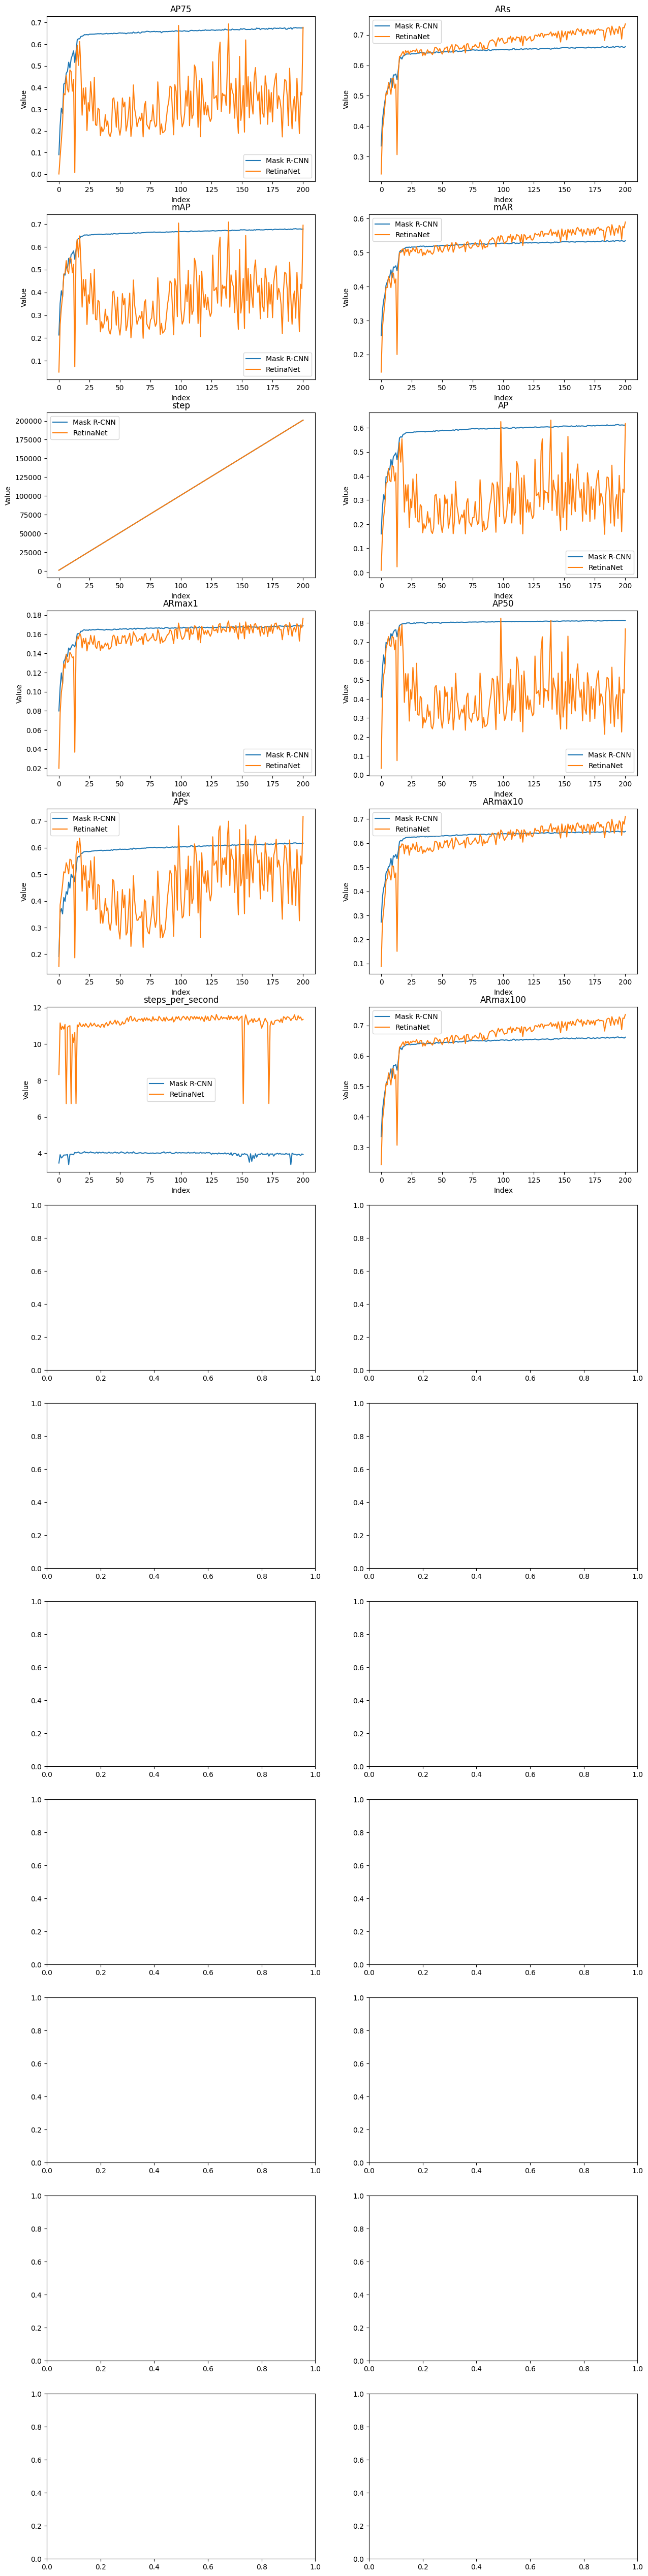

In [28]:
n_cols = len(merged_df.columns)
n_rows = (n_cols + 1) // 2  # Round up to the nearest integer

# Create subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each column
for i, col in enumerate(cols):
    axes[i].plot(merged_df[col + "_df1"], label="Mask R-CNN")
    axes[i].plot(merged_df[col + "_df2"], label="RetinaNet")
    axes[i].set_title(col)
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Value')
    axes[i].legend()

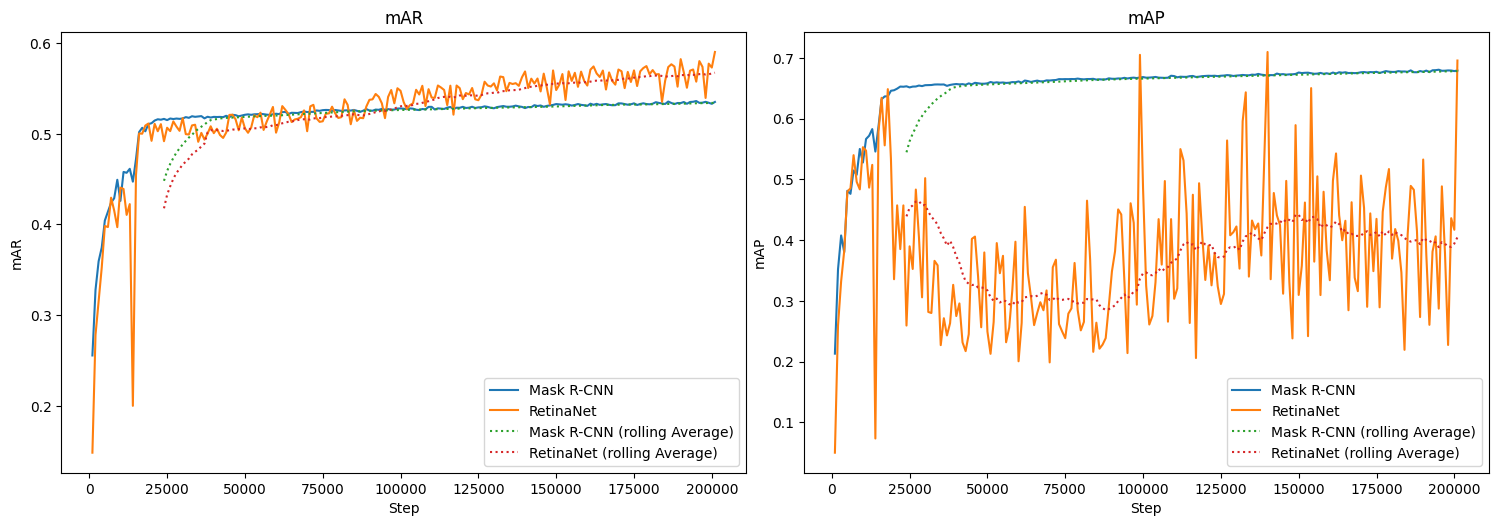

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.tight_layout()
# Flatten the axes array for easier indexing
axes = axes.flatten()

rolling_window_size = 24

for i, col in enumerate(["mAR", "mAP"]):
    axes[i].plot(merged_df["step_df1"], merged_df[col + "_df1"], label="Mask R-CNN")
    axes[i].plot(merged_df["step_df2"], merged_df[col + "_df2"],  label="RetinaNet")
    axes[i].plot(merged_df["step_df1"], merged_df[col + "_df1"].rolling(window=rolling_window_size).mean(), ':', label="Mask R-CNN (rolling Average)")
    axes[i].plot(merged_df["step_df2"], merged_df[col + "_df2"].rolling(window=rolling_window_size).mean(), ':', label="RetinaNet (rolling Average)")
    axes[i].set_title(col)
    axes[i].set_xlabel('Step')
    axes[i].set_ylabel(col)
    axes[i].legend()
fig.show()
fig.savefig("mean.png")

In [30]:
merged_df.max(axis='rows')

ARmax100_df1                 0.662498
ARmax100_df2                 0.736139
ARs_df1                      0.662498
ARs_df2                      0.736139
AP75_df1                     0.677083
AP75_df2                     0.693964
step_df1                201000.000000
step_df2                201000.000000
AP_df1                       0.613448
AP_df2                       0.631502
ARmax1_df1                   0.169103
ARmax1_df2                   0.176756
AP50_df1                     0.812916
AP50_df2                     0.824622
APs_df1                      0.618294
APs_df2                      0.717963
ARmax10_df1                  0.650027
ARmax10_df2                  0.711197
steps_per_second_df1         4.092400
steps_per_second_df2        11.622756
validation_loss_df2          7.781787
mAR_df1                      0.535973
mAP_df1                      0.680329
mAR_df2                      0.590058
mAP_df2                      0.709540
dtype: float64

In [31]:
merged_df.diff(axis='rows').std()

ARmax100_df1            0.008801
ARmax100_df2            0.030775
ARs_df1                 0.008801
ARs_df2                 0.030775
AP75_df1                0.017193
AP75_df2                0.141601
step_df1                0.000000
step_df2                0.000000
AP_df1                  0.012921
AP_df2                  0.127650
ARmax1_df1              0.002952
ARmax1_df2              0.013343
AP50_df1                0.015739
AP50_df2                0.169666
APs_df1                 0.014762
APs_df2                 0.125523
ARmax10_df1             0.010299
ARmax10_df2             0.044695
steps_per_second_df1    0.117155
steps_per_second_df2    0.994703
validation_loss_df2     0.867000
mAR_df1                 0.007500
mAP_df1                 0.014737
mAR_df2                 0.029712
mAP_df2                 0.140083
dtype: float64

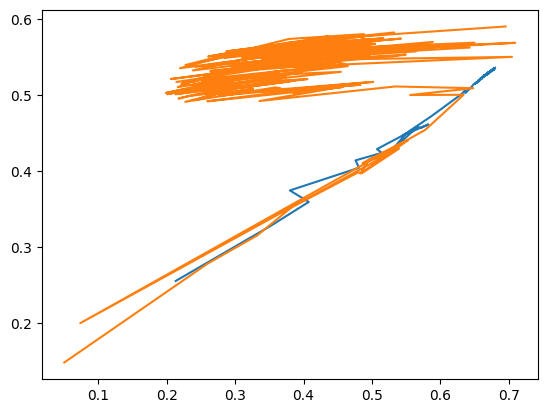

In [32]:
fig = plt.figure()
plt.plot(merged_df["mAP_df1"], merged_df["mAR_df1"])
plt.plot(merged_df["mAP_df2"], merged_df["mAR_df2"])
plt.show()